In [436]:
# Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [437]:
# read in MSOA data
msoas = pd.read_csv(
    "msoa-data-old-boundaries.csv", low_memory=False, encoding="unicode_escape"
)

msoas_shape = gpd.read_file("statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")

In [438]:
# read in incidents data, filter for dwelling fires in 2011, convert to GDF
incidents = pd.read_csv("LFB Incident data from 2009 - 2017.csv", low_memory=False)

incidents = incidents[incidents.IncidentGroup == "Fire"]
incidents = incidents[
    (incidents.PropertyCategory == "Dwelling")
    | (incidents.PropertyCategory == "Other Residential")
]
incidents = incidents[incidents.CalYear == 2011]
incidents = gpd.GeoDataFrame(
    incidents,
    geometry=gpd.points_from_xy(
        incidents["Easting_rounded"], incidents["Northing_rounded"], crs=msoas_shape.crs
    ),
)

In [439]:
# select variables and make % calculations as necessary
msoas = msoas[ 
    [
        "MSOA Name",
        "Middle Super Output Area",
        "Tenure (2011);Social rented (%);",
        "Dwelling type (2011);All Households;",
        "Dwelling type (2011);Flat, maisonette or apartment (%);",
        "Tenure (2011);Owned: Owned outright (%);",
        "Tenure (2011);Owned: Owned with a mortgage or loan (%);",
        "Population Density;Persons per hectare (2011);",
        "Household Language (2011);% of households where no people in household have English as a main language;",
        "Economic Activity (2011 Census);Economically active: % Unemployed;",
        "Qualifications (2011 Census);No qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Apprenticeship;",
        "Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;",
        "Qualifications (2011 Census);Highest level of qualification: Other qualifications;",
        "Qualifications (2011 Census);Schoolchildren and full-time students: Age 18 and over;",
        "Household Income (£);Average Weekly Household Total Income Estimate;2007/08",
        "Age Structure (2011 Census);65+;",
        "Age Structure (2011 Census);0-15;",
        "Age Structure (2011 Census);All Ages;",
    ]
]

# calculate % education level 4
msoas["pct_education_level_4"] = msoas[
    "Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;"
] / sum(
    [
        msoas["Qualifications (2011 Census);No qualifications;"],
        msoas[
            "Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;"
        ],
        msoas[
            "Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;"
        ],
        msoas[
            "Qualifications (2011 Census);Highest level of qualification: Apprenticeship;"
        ],
        msoas[
            "Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;"
        ],
        msoas[
            "Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;"
        ],
        msoas[
            "Qualifications (2011 Census);Highest level of qualification: Other qualifications;"
        ],
        msoas[
            "Qualifications (2011 Census);Schoolchildren and full-time students: Age 18 and over;"
        ],
    ]
)

msoas["pct_young"] = (
    100
    * msoas["Age Structure (2011 Census);0-15;"]
    / msoas["Age Structure (2011 Census);All Ages;"]
)

msoas["pct_old"] = (
    100
    * msoas["Age Structure (2011 Census);65+;"]
    / msoas["Age Structure (2011 Census);All Ages;"]
)

msoas["pct_owned"] = msoas['Tenure (2011);Owned: Owned outright (%);'] + msoas['Tenure (2011);Owned: Owned with a mortgage or loan (%);']

msoas = msoas.drop(
    columns=[
        "Age Structure (2011 Census);65+;",
        "Age Structure (2011 Census);0-15;",
        "Age Structure (2011 Census);All Ages;",
        "Qualifications (2011 Census);No qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Apprenticeship;",
        "Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;",
        "Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;",
        "Qualifications (2011 Census);Highest level of qualification: Other qualifications;",
        "Qualifications (2011 Census);Schoolchildren and full-time students: Age 18 and over;",
        "Tenure (2011);Owned: Owned outright (%);",
        "Tenure (2011);Owned: Owned with a mortgage or loan (%);"
    ]
)

msoas = msoas.rename(
    columns={
        "Tenure (2011);Social rented (%);": "pct_social_rented",
        "Dwelling type (2011);Flat, maisonette or apartment (%);": "pct_flat",
        "Dwelling type (2011);All Households;": "households",
        "Population Density;Persons per hectare (2011);": "population_density",
        "Household Language (2011);% of households where no people in household have English as a main language;": "pct_no_english",
        "Economic Activity (2011 Census);Economically active: % Unemployed;": "unemployment",
        "Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;": "pct_education_level_4",
        "Household Income (£);Average Weekly Household Total Income Estimate;2007/08": "avg_income",
    }
)


In [440]:
# get the fire incident counts per msoa
joined = gpd.sjoin(msoas_shape, incidents)  # spatial join incidents and msoas
joined.reset_index(drop=True, inplace=True)

property_type_by_msoa = (
    joined.groupby(["MSOA11CD", "PropertyType"])
    .size()
    .groupby(["MSOA11CD", "PropertyType"])
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

In [441]:
# aggregate response time and incident count by MSOA
count = joined.groupby("MSOA11CD").agg(
    {"FirstPumpArriving_AttendanceTime": "mean", "IncidentNumber": "count"}
)

count = count[~count.FirstPumpArriving_AttendanceTime.isna()].reset_index()

msoas_joined = pd.merge(
    msoas, count, how="left", left_on="Middle Super Output Area", right_on="MSOA11CD"
).rename(
    columns={
        "IncidentNumber": "fire_count",
        "FirstPumpArriving_AttendanceTime": "response_time",
    }
)

msoas_joined = msoas_joined[msoas_joined["MSOA Name"] != "MSOA average for London"]

property_type_by_msoa = pd.merge(
    property_type_by_msoa, count[["MSOA11CD", "IncidentNumber"]]
)

In [442]:
property_type_by_msoa["HMO"] = (
    property_type_by_msoa[
        "House in Multiple Occupation - 3 or more storeys (not known if licensed)"
    ]
    + property_type_by_msoa[
        "House in Multiple Occupation - Up to 2 storeys (not known if licensed) "
    ]
    + property_type_by_msoa[
        "Licensed House in Multiple Occupation - 3 or more storeys "
    ]
    + property_type_by_msoa["Licensed House in Multiple Occupation - Up to 2 storeys "]
    + property_type_by_msoa[
        "Unlicensed House in Multiple Occupation - 3 or more storeys "
    ]
    + property_type_by_msoa[
        "Unlicensed House in Multiple Occupation - Up to 2 storeys "
    ]
)

property_type_by_msoa["flat"] = (
    property_type_by_msoa["Converted Flat/Maisonette - Up to 2 storeys "]
    + property_type_by_msoa["Converted Flat/Maisonettes - 3 or more storeys"]
    + property_type_by_msoa["Purpose Built Flats/Maisonettes - 10 or more storeys "]
    + property_type_by_msoa["Purpose Built Flats/Maisonettes - 4 to 9 storeys "]
    + property_type_by_msoa["Purpose Built Flats/Maisonettes - Up to 3 storeys "]
)

property_type_by_msoa["self_contained"] = (
    property_type_by_msoa["Caravan/Mobile home (permanent dwelling)"]
    + property_type_by_msoa["House - single occupancy "]
    + property_type_by_msoa["Houseboat (permanent dwelling) "]
    + property_type_by_msoa["Self contained Sheltered Housing "]
)

property_type_by_msoa["3_more_storeys"] = (
    property_type_by_msoa[
        "House in Multiple Occupation - 3 or more storeys (not known if licensed)"
    ]
    + property_type_by_msoa["Converted Flat/Maisonettes - 3 or more storeys"]
    + property_type_by_msoa["Purpose Built Flats/Maisonettes - 10 or more storeys "]
    + property_type_by_msoa["Purpose Built Flats/Maisonettes - 4 to 9 storeys "]
    + property_type_by_msoa[
        "Unlicensed House in Multiple Occupation - 3 or more storeys "
    ]
    + property_type_by_msoa[
        "Licensed House in Multiple Occupation - 3 or more storeys "
    ]
)

for col in property_type_by_msoa.columns:
    if col != "MSOA11CD" and col != "IncidentNumber":
        property_type_by_msoa[f"pct_{col}"] = (
            100 * property_type_by_msoa[col] / property_type_by_msoa["IncidentNumber"]
        )
        # property_type_by_msoa = property_type_by_msoa.drop(columns=col)

In [443]:
msoas_joined = pd.merge(
    msoas_joined,
    property_type_by_msoa[["MSOA11CD", "pct_self_contained", "pct_3_more_storeys"]],
    left_on="Middle Super Output Area",
    right_on="MSOA11CD",
)

# calculate fire incidents per 10,000 households
msoas_joined["fires_per_ten_thousand_households"] = (
    msoas_joined.fire_count / msoas_joined.households * 10000
)

# transform variables for normal distribution
msoas_joined["sqrt_pct_social_rented"] = np.sqrt(msoas_joined.pct_social_rented)
msoas_joined["sqrt_fires"] = np.sqrt(msoas_joined.fires_per_ten_thousand_households)

msoas_joined["sqrt_no_english"] = np.sqrt(msoas_joined.pct_no_english)

msoas_joined["log_unemployment"] = np.log(msoas_joined.unemployment)

msoas_joined["sqrt_population_density"] = np.sqrt(msoas_joined.population_density)

msoas_joined["log_response_time"] = np.log(msoas_joined.response_time)

msoas_joined['log_old'] = np.log(msoas_joined.pct_old)

msoas_joined['log_income'] = np.log(msoas_joined.avg_income)


sqrt_pct_social_rented and sqrt_fires
Params: Intercept                 2.956941
sqrt_pct_social_rented    0.335232
dtype: float64
p-values: Intercept                 1.756494e-146
sqrt_pct_social_rented     5.030460e-58
dtype: float64
R-squared: 0.24180588204474585


log_unemployment and sqrt_fires
Params: Intercept           1.714386
log_unemployment    1.440635
dtype: float64
p-values: Intercept           4.054007e-23
log_unemployment    1.518770e-55
dtype: float64
R-squared: 0.23249024080483705


pct_flat and sqrt_fires
Params: Intercept    3.607820
pct_flat     0.017633
dtype: float64
p-values: Intercept    4.081832e-241
pct_flat      1.645735e-33
dtype: float64
R-squared: 0.1446370959345532


sqrt_population_density and sqrt_fires
Params: Intercept                  3.269286
sqrt_population_density    0.138790
dtype: float64
p-values: Intercept                  9.469583e-114
sqrt_population_density     2.641571e-23
dtype: float64
R-squared: 0.10074059330180662


sqrt_no_english an

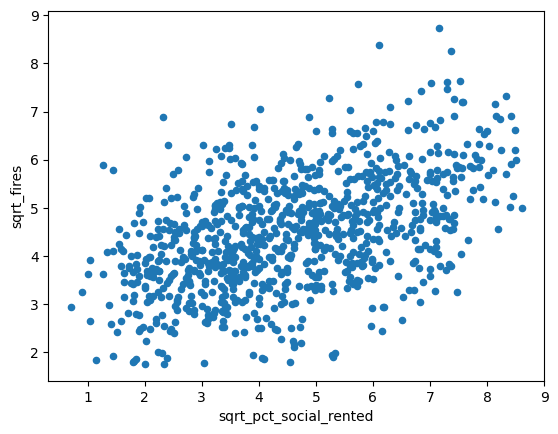

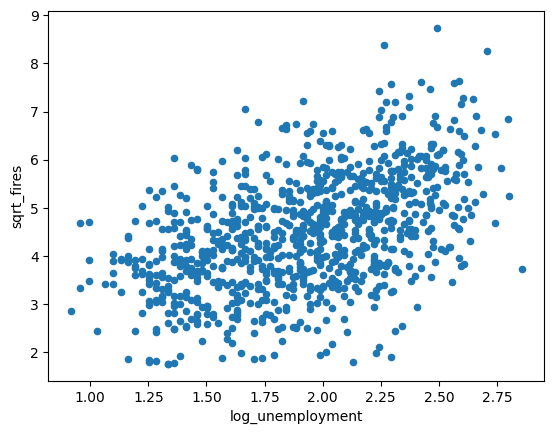

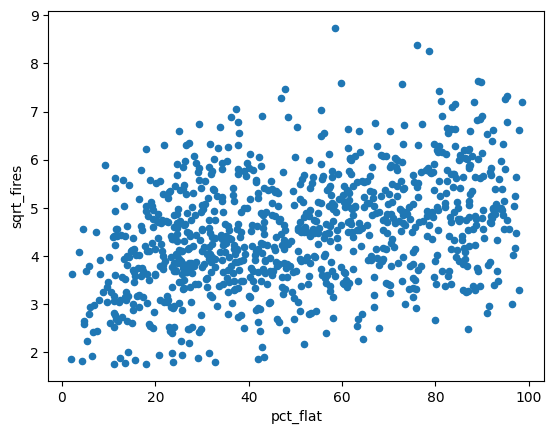

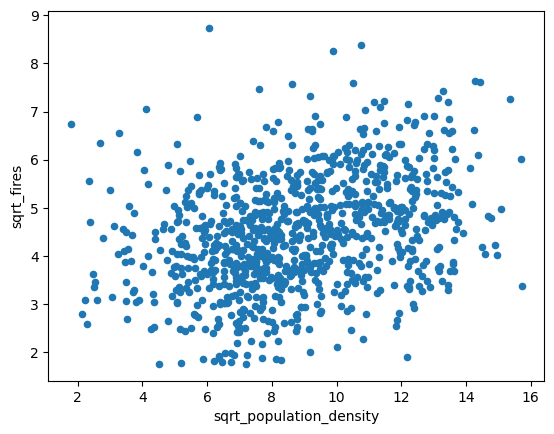

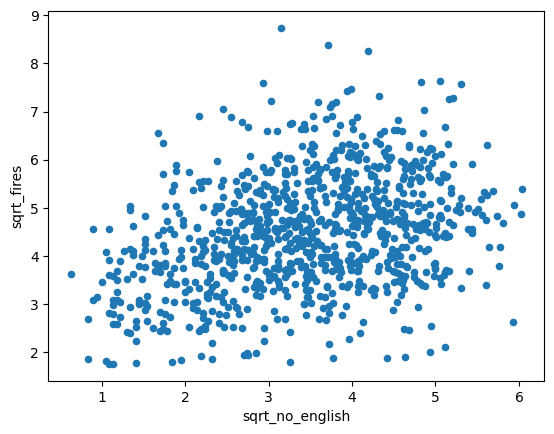

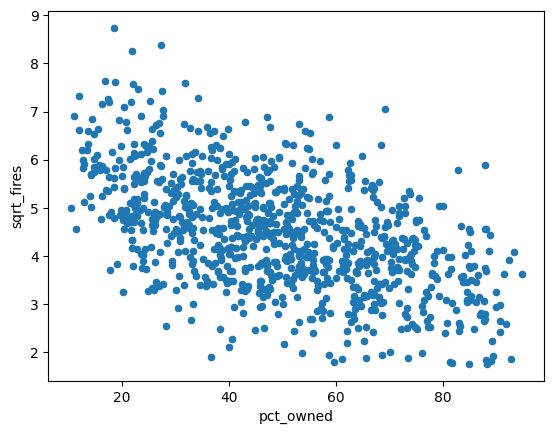

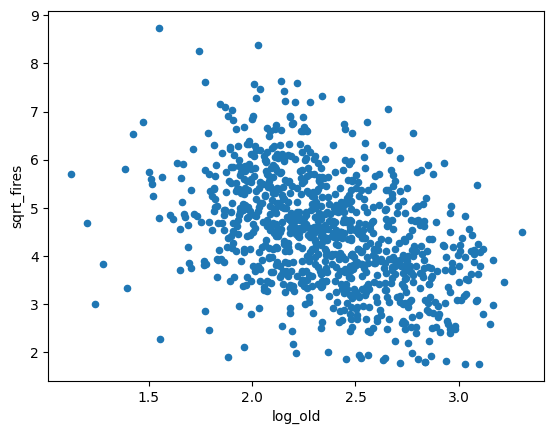

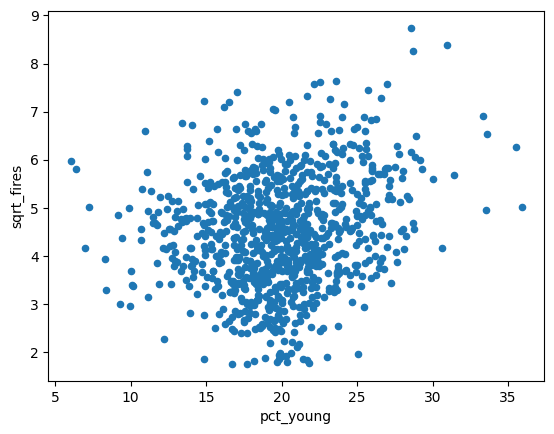

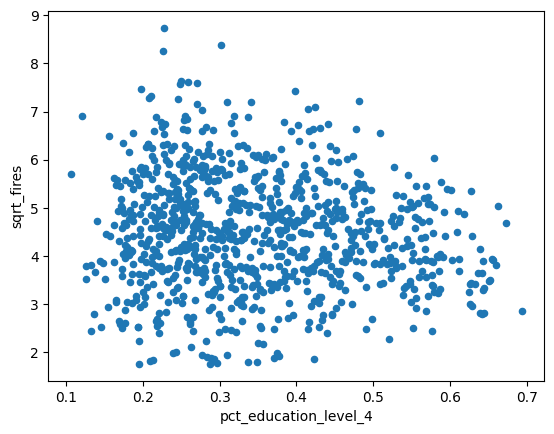

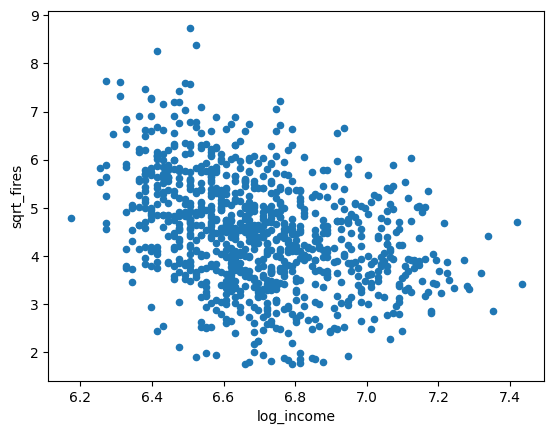

In [444]:
def linear_regression(df, x, y):
    print(x + " and " + y)

    # plot
    df.plot(kind="scatter", x=x, y=y)

    lm = smf.ols(formula=y + " ~ " + x, data=df).fit()

    print("Params: " + str(lm.params))
    print("p-values: " + str(lm.pvalues))
    print("R-squared: " + str(lm.rsquared))
    print("\n")

    return lm


linear_regression(msoas_joined, "sqrt_pct_social_rented", "sqrt_fires")

linear_regression(msoas_joined, "log_unemployment", "sqrt_fires")

linear_regression(msoas_joined, "pct_flat", "sqrt_fires")

linear_regression(msoas_joined, "sqrt_population_density", "sqrt_fires")

linear_regression(msoas_joined, "sqrt_no_english", "sqrt_fires")

linear_regression(msoas_joined, "pct_owned", "sqrt_fires")

linear_regression(msoas_joined, "log_old", "sqrt_fires")

linear_regression(msoas_joined, "pct_young", "sqrt_fires")

linear_regression(msoas_joined, "pct_education_level_4", "sqrt_fires")

linear_regression(msoas_joined, "log_income", "sqrt_fires")

sqrt_pct_social_rented and log_response_time
Params: Intercept                 5.931889
sqrt_pct_social_rented   -0.043951
dtype: float64
p-values: Intercept                 0.000000e+00
sqrt_pct_social_rented    2.585258e-22
dtype: float64
R-squared: 0.09637010369752341


log_unemployment and log_response_time
Params: Intercept           5.978357
log_unemployment   -0.128426
dtype: float64
p-values: Intercept           0.000000e+00
log_unemployment    1.700324e-10
dtype: float64
R-squared: 0.042838258765544035


pct_flat and log_response_time
Params: Intercept    5.914434
pct_flat    -0.003670
dtype: float64
p-values: Intercept    0.000000e+00
pct_flat     1.180002e-33
dtype: float64
R-squared: 0.1452437253950667


sqrt_population_density and log_response_time
Params: Intercept                  6.055378
sqrt_population_density   -0.036903
dtype: float64
p-values: Intercept                  0.000000e+00
sqrt_population_density    1.903917e-38
dtype: float64
R-squared: 0.165132549444360

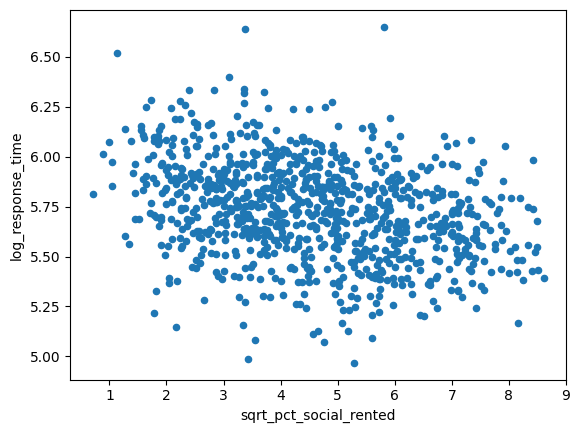

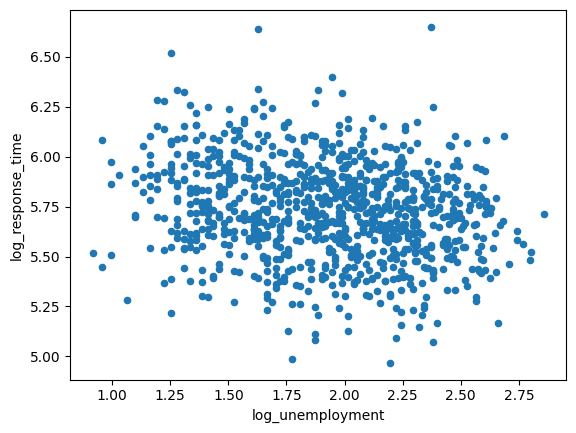

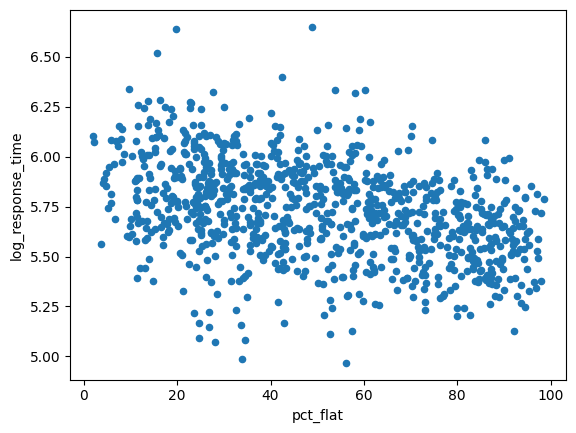

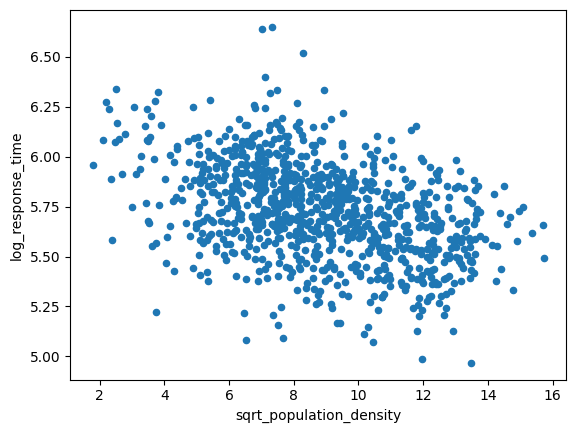

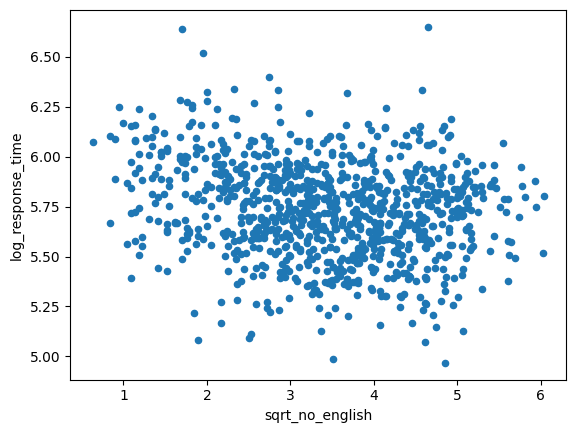

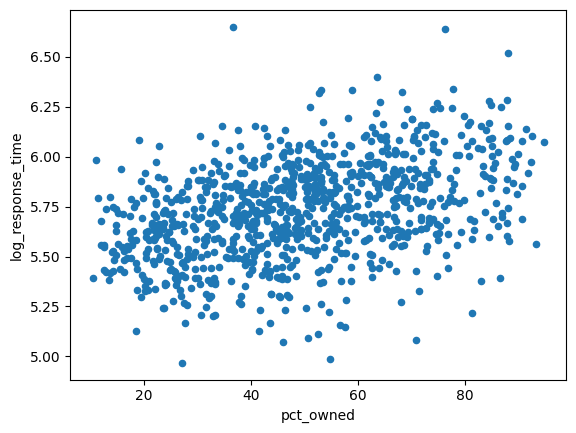

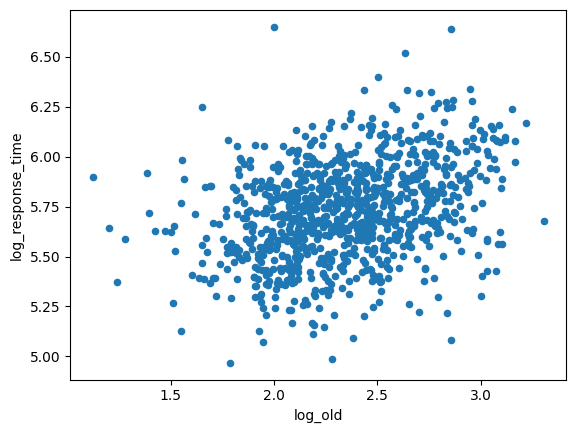

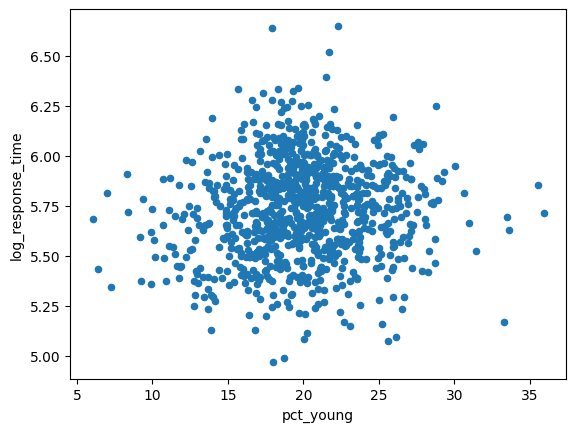

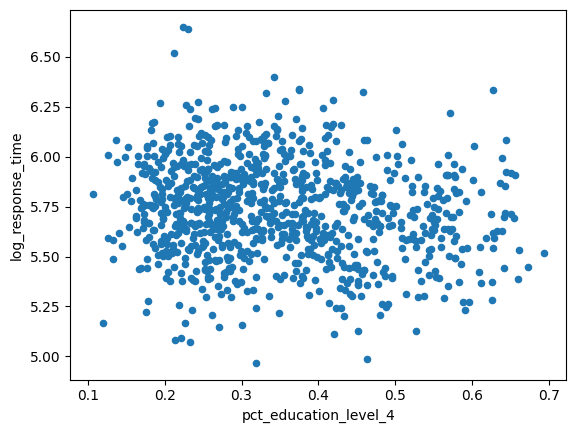

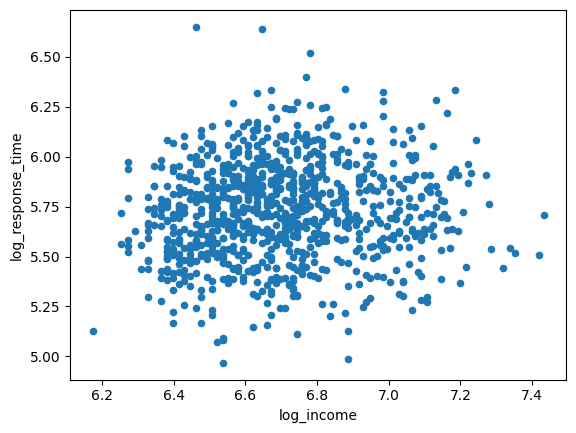

In [445]:
linear_regression(msoas_joined, "sqrt_pct_social_rented", "log_response_time")

linear_regression(msoas_joined, "log_unemployment", "log_response_time")

linear_regression(msoas_joined, "pct_flat", "log_response_time")

linear_regression(msoas_joined, "sqrt_population_density", "log_response_time")

linear_regression(msoas_joined, "sqrt_no_english", "log_response_time")

linear_regression(msoas_joined, "pct_owned", "log_response_time")

linear_regression(msoas_joined, "log_old", "log_response_time")

linear_regression(msoas_joined, "pct_young", "log_response_time")

linear_regression(msoas_joined, "pct_education_level_4", "log_response_time")

linear_regression(msoas_joined, "log_income", "log_response_time")

In [446]:
# modified from https://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
           ensuring condition number is less than 1000
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while (
        remaining and current_score == best_new_score
    ):  # as long as remaining is not empty and the current score is better than the last
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(
                response, " + ".join(selected + [candidate])
            )  # linear regression with current candidate and already selected
            score = smf.ols(formula, data).fit().rsquared_adj
            cond_no = smf.ols(formula, data).fit().condition_number
            scores_with_candidates.append(
                (score, candidate, cond_no)
            )  # add score and candidate to list
        scores_with_candidates.sort()
        best_new_score, best_candidate, cond_no = (
            scores_with_candidates.pop()
        )  # selects best candidate/score in remaining
        if (current_score < best_new_score) and (
            cond_no < 1000
        ):  # if the best new score is better and condition number reasonable, add best_candidate to selected
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, " + ".join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [447]:
# stepwise regression for fire
data = msoas_joined[
    [
        "sqrt_pct_social_rented",
        "log_unemployment",
        "sqrt_no_english",
        "pct_flat",
        "sqrt_population_density",
        "pct_self_contained",
        "pct_owned",
        "pct_young",
        "pct_education_level_4",
        "sqrt_fires",
        "log_old",
        "log_income"
    ]
]

model = forward_selected(data, "sqrt_fires")

print(model.model.formula)

print(model.rsquared_adj)

model.summary()

sqrt_fires ~ pct_owned + log_unemployment + pct_young + 1
0.3199434115635845


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_fires   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     147.3
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           4.21e-78
Time:                        19:48:21   Log-Likelihood:                -1292.1
No. Observations:                 934   AIC:                             2592.
Df Residuals:                     930   BIC:                             2612.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.3611      0.287     15.218      0.000       3.799       4.924
pct_owned           -0.0260      0.002    -10.411      0.000      -0.031      -0.021
log_unemployment     0.4498      0.152      2.961      0.003       0.152       0.748
pct_young            0.0270      0.011      2.422      0.016       0.005       0.049
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.412
Skew:                           0.050   Prob(JB):                        0.814
Kurtosis:                       3.027   Cond. No.                         554.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [448]:
# below code taken from practical 5
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
def drop_column_using_vif(df, thresh=5):
    """
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    """
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series(
            [
                variance_inflation_factor(df_with_const.values, i)
                for i in range(df_with_const.shape[1])
            ],
            name="VIF",
            index=df_with_const.columns,
        ).to_frame()

        # drop the const
        vif_df = vif_df.drop("const")

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print("Dropping: {}".format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [449]:
msoas_vif_1 = drop_column_using_vif(msoas_joined[['pct_owned','log_unemployment','pct_young']])

fire_model_1 = sm.OLS(
    endog=msoas_joined[["sqrt_fires"]], exog=sm.add_constant(msoas_vif_1)
).fit()
fire_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_fires   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     147.3
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           4.21e-78
Time:                        19:48:21   Log-Likelihood:                -1292.1
No. Observations:                 934   AIC:                             2592.
Df Residuals:                     930   BIC:                             2612.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.3611      0.287     15.218      0.000       3.799       4.924
pct_owned           -0.0260      0.002    -10.411      0.000      -0.031      -0.021
log_unemployment     0.4498      0.152      2.961      0.003       0.152       0.748
pct_young            0.0270      0.011      2.422      0.016       0.005       0.049
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.412
Skew:                           0.050   Prob(JB):                        0.814
Kurtosis:                       3.027   Cond. No.                         554.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [450]:
msoas_vif_2 = drop_column_using_vif(msoas_joined[['sqrt_no_english','log_unemployment','sqrt_pct_social_rented']])

fire_model_2 = sm.OLS(
    endog=msoas_joined[["sqrt_fires"]], exog=sm.add_constant(msoas_vif_2)
).fit()
fire_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_fires   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     128.5
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           1.18e-69
Time:                        19:48:21   Log-Likelihood:                -1311.7
No. Observations:                 934   AIC:                             2631.
Df Residuals:                     930   BIC:                             2651.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.9513      0.172     11.376      0.000       1.615       2.288
sqrt_no_english            0.1801      0.033      5.457      0.000       0.115       0.245
log_unemployment           0.4783      0.137      3.503      0.000       0.210       0.746
sqrt_pct_social_rented     0.2184      0.029      7.585      0.000       0.162       0.275
==============================================================================
Omnibus:                        1.378   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.260
Skew:                           0.039   Prob(JB):                        0.533
Kurtosis:                       3.162   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [451]:
data = msoas_joined[
    [
        "pct_flat",
        "sqrt_population_density",
        "log_unemployment",
        "sqrt_no_english",
        "sqrt_pct_social_rented",
        "pct_self_contained",
        "pct_owned",
        "pct_young",
        "pct_education_level_4",
        "log_old",
        "log_income",
        "log_response_time"
    ]
]

model = forward_selected(data, "log_response_time")

print(model.model.formula)

print(model.rsquared_adj)

log_response_time ~ pct_owned + sqrt_population_density + sqrt_no_english + pct_education_level_4 + pct_self_contained + 1
0.21412702184878496


In [452]:
response_vif = drop_column_using_vif(msoas_joined[['sqrt_pct_social_rented','sqrt_population_density','pct_education_level_4']])

model = sm.OLS(
    endog=msoas_joined[["log_response_time"]], exog=sm.add_constant(response_vif)
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_response_time   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     77.86
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           6.16e-45
Time:                        19:48:21   Log-Likelihood:                 98.984
No. Observations:                 934   AIC:                            -190.0
Df Residuals:                     930   BIC:                            -170.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       6.1861      0.033    186.707      0.000       6.121       6.251
sqrt_pct_social_rented     -0.0313      0.005     -6.176      0.000      -0.041      -0.021
sqrt_population_density    -0.0251      0.003     -7.732      0.000      -0.031      -0.019
pct_education_level_4      -0.2647      0.064     -4.142      0.000      -0.390      -0.139
==============================================================================
Omnibus:                       12.782   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.808
Skew:                          -0.181   Prob(JB):                     0.000369
Kurtosis:                       3.525   Cond. No.                         98.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [453]:
del (response_vif,
    msoas_joined,
    msoas,
    incidents,
    msoas_shape,
    joined,
    count,
    fire_model_1,
    fire_model_2,
    msoas_vif_1,
    msoas_vif_2,
    property_type_by_msoa,
    col,
    data,
    model)